In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, MaternKernel

import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"..")

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP

In [2]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
input_dim = 2
N = 500
train_x = None
train_y = None

# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = ScaleKernel(RBFKernel(ard_num_dims=input_dim))
kernel2 = ScaleKernel(ProductKernel(RBFKernel(ard_num_dims=input_dim), LinearKernel()))
model1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel1)
model2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel2)

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor([.9, .3]),
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.kernels.0.lengthscale': torch.tensor([.4, .8]),
        # 'covar_module.base_kernel.period_length': torch.tensor([.8, .3, .8, .6])
    }
]

torch.manual_seed(55)
X = torch.linspace(0,1,N)
X = torch.stack([X, torch.randn(N)]).T
Y = torch.empty((N,2))

In [3]:
A = torch.tensor([
    [ -0.1000, 0.900], # f_11 Poisson
    [ 0.8000, 0.800], # f_21 HetGaussian
    [ -0.1000,  0.1000], # f_22 HetGaussian
    [ -0.2000,  0.9500], # f_22 Bernoulli
])

torch.manual_seed(55)
model1.initialize(**hypers[0])
model1.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,0] = model1(X).sample()
    
torch.manual_seed(2)
model2.initialize(**hypers[1])
model2.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,1] = model2(X).sample()
    
torch.manual_seed(55)
f_11 = Y @ A[0,:]
y_1 = dist.Poisson(f_11.exp())()

torch.manual_seed(55)
f_21 = Y @ A[1,:]
f_22 = Y @ A[2,:]
y_2 = torch.normal(f_21, f_22.exp())

torch.manual_seed(55)
f_31 = Y @ A[3,:]
y_3 = dist.Bernoulli(torch.sigmoid(f_31))()

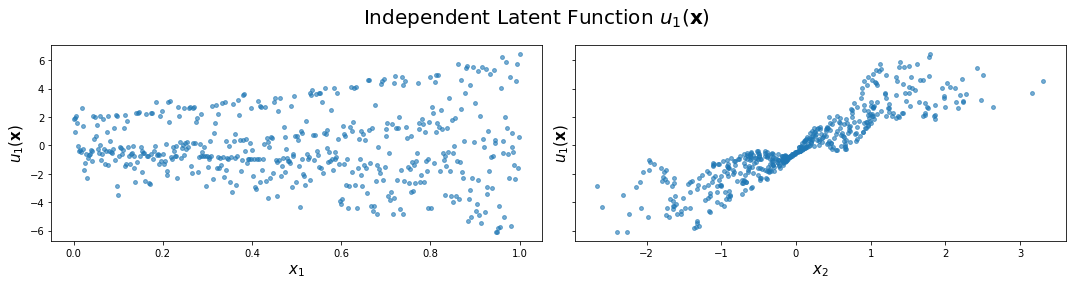

In [4]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,4))

ax[0].scatter(X[:,0], Y[:,0], s=15, alpha=.6, marker='o')
ax[1].scatter(X[:,1], Y[:,0], s=15, alpha=.6, marker='o')

ax[0].set_ylabel(r"$u_1(\mathbf{x})$", fontdict={'fontsize':15})
ax[0].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1].set_ylabel(r"$u_1(\mathbf{x})$", fontdict={'fontsize':15})
ax[1].set_xlabel(r"$x_2$", fontdict={'fontsize':15})

fig.suptitle(r"Independent Latent Function $u_1(\mathbf{x})$", fontsize=20)
fig.tight_layout()

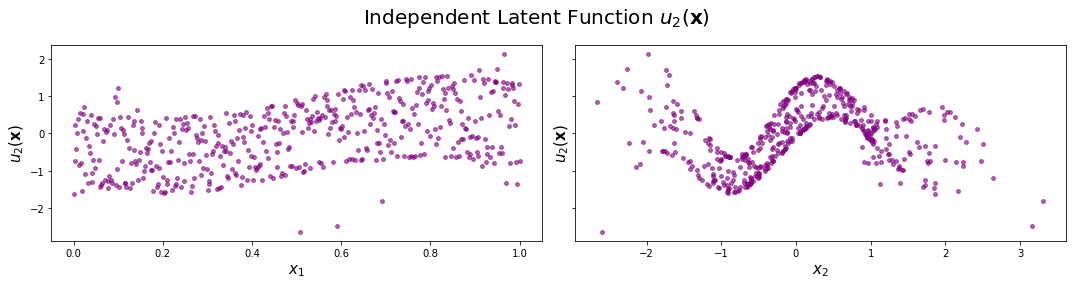

In [5]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,4))

ax[0].scatter(X[:,0], Y[:,1], s=15, alpha=.6, marker='o', c="purple")
ax[1].scatter(X[:,1], Y[:,1], s=15, alpha=.6, marker='o', c="purple")

ax[0].set_ylabel(r"$u_2(\mathbf{x})$", fontdict={'fontsize':15})
ax[0].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1].set_ylabel(r"$u_2(\mathbf{x})$", fontdict={'fontsize':15})
ax[1].set_xlabel(r"$x_2$", fontdict={'fontsize':15})

fig.suptitle(r"Independent Latent Function $u_2(\mathbf{x})$", fontsize=20)
fig.tight_layout()

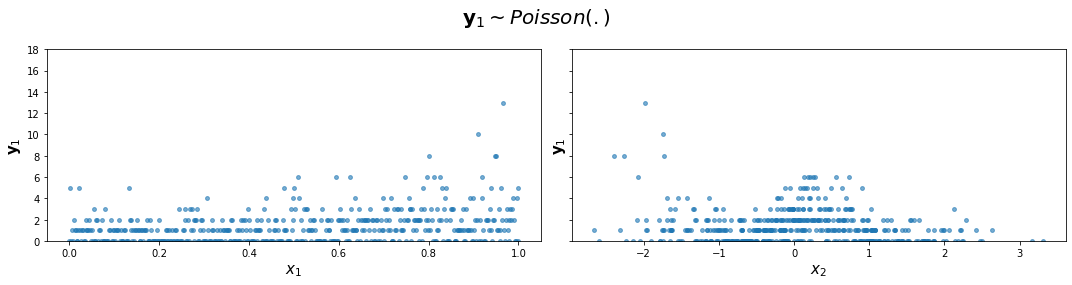

In [6]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,4))

ax[0].scatter(X[:,0], y_1, s=15, alpha=.6, marker='o')
ax[0].set_ylim([0,18])
ax[1].scatter(X[:,1], y_1, s=15, alpha=.6, marker='o')

ax[0].set_ylabel(r"$\mathbf{y}_1$", fontdict={'fontsize':15})
ax[0].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1].set_ylabel(r"$\mathbf{y}_1$", fontdict={'fontsize':15})
ax[1].set_xlabel(r"$x_2$", fontdict={'fontsize':15})

fig.suptitle(r"$\mathbf{y}_1 \sim Poisson(.)$", fontsize=20)
fig.tight_layout()

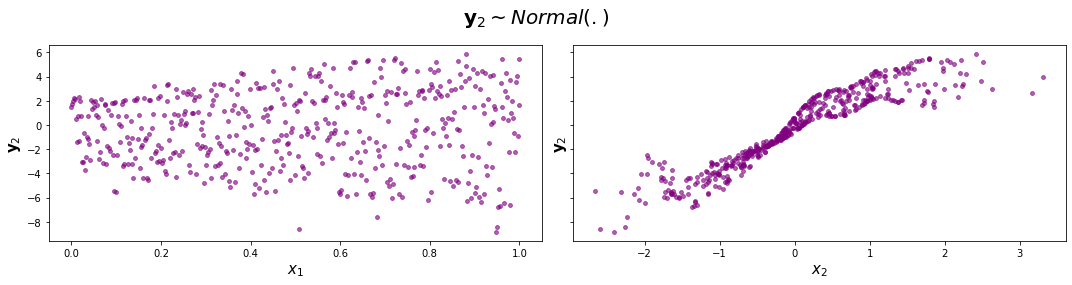

In [7]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,4))

ax[0].scatter(X[:,0], y_2, s=15, alpha=.6, marker='o', c="purple")
# ax[0].set_ylim([0,10])
ax[1].scatter(X[:,1], y_2, s=15, alpha=.6, marker='o', c="purple")

ax[0].set_ylabel(r"$\mathbf{y}_2$", fontdict={'fontsize':15})
ax[0].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1].set_ylabel(r"$\mathbf{y}_2$", fontdict={'fontsize':15})
ax[1].set_xlabel(r"$x_2$", fontdict={'fontsize':15})

fig.suptitle(r"$\mathbf{y}_2 \sim Normal(.)$", fontsize=20)
fig.tight_layout()

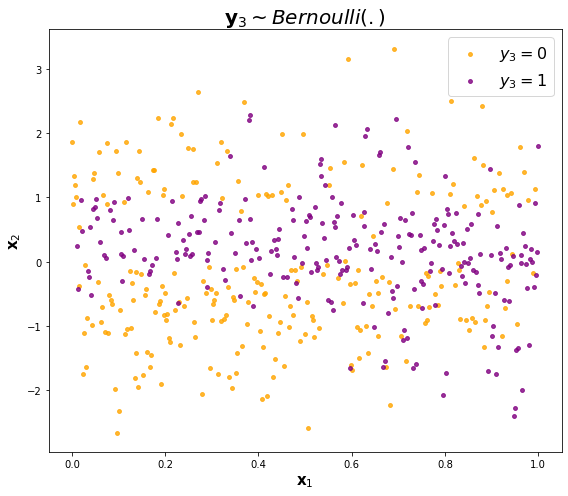

In [8]:
fig, ax = plt.subplots(figsize=(8,7))
idx_0 = (y_3==0).nonzero().flatten()
idx_1 = (y_3==1).nonzero().flatten()
ax.scatter(X[idx_0,0], X[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
ax.scatter(X[idx_1,0], X[idx_1,1], s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
ax.legend(prop={'size': 16})

ax.set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
ax.set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
ax.set_title(r"$\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);
fig.tight_layout()

## Training the model

In [9]:
train_idx, test_idx = torch.utils.data.random_split(X, [.7, .3])
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx,:]
test_x = X[test_idx,:]
full_y = torch.stack([y_1, y_2, y_3], dim=-1)
train_y = full_y[train_idx,:]
test_y = full_y[test_idx,:]

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

gamma_mean = 2
gamma_std = 2
alpha = gamma_mean**2 / np.sqrt(gamma_std)
beta = gamma_mean / np.sqrt(gamma_std)
lengthscale_prior = gpytorch.priors.GammaPrior(alpha, beta)

batch_shape=torch.Size([3])

kernels= [ScaleKernel(ProductKernel(LinearKernel(batch_shape=batch_shape),
                                          RBFKernel(lengthscale_prior=lengthscale_prior,batch_shape=batch_shape)),batch_shape=batch_shape),
                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, batch_shape=batch_shape), batch_shape=batch_shape),
                ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior, batch_shape=batch_shape), batch_shape=batch_shape)]

likelihoods = ["Poisson", "HetGaussian", "Bernoulli"]
# active_dims = [[0,1], [0,1]]

HetMOGP.ELBO_NORMALISER = train_y.size(0)
model = HetMOGP(train_x, num_lpf=4, likelihoods=likelihoods, kernels=kernels, num_inducing=100, jitter_val = 1e-9)

if torch.cuda.is_available():
    model = model.cuda()

In [10]:
pyro.clear_param_store()

num_iter = 1200 # for actual training
# num_iter = 500 # for testing if the code works
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 (for fast training, try final_lr = 1e-2)

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(x=train_x, y=train_y)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1200 [00:00<?, ?it/s]

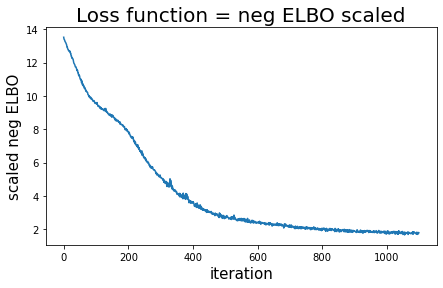

In [13]:
loss_start = 100
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])
ax.set_xlabel(r"iteration", fontdict={'fontsize':15})
ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':15})
ax.set_title(r"Loss function = neg ELBO scaled", fontsize=20);

In [119]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [120]:
n_posterior_samples = 1000

model.eval()

with torch.no_grad():
    output = model(test_x)
    output_train = model(train_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([n_posterior_samples]))
samples_train = output_train(torch.Size([n_posterior_samples]))

lower, mean, upper = percentiles_from_samples(samples.cpu())
lower_train, mean_train, upper_train = percentiles_from_samples(samples_train.cpu())
train_x, train_y, test_x, test_y = train_x.cpu(), train_y.cpu(), test_x.cpu(), test_y.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Poisson(mean[:,0].detach().exp())(), 
     dist.Normal(mean[:,1].detach(), mean[:,2].detach().exp())(),
     dist.Bernoulli(torch.sigmoid(mean[:,3].detach()))()],
    dim=-1
)

y_sim_train = torch.stack(
    [dist.Poisson(mean_train[:,0].detach().exp())(), 
     dist.Normal(mean_train[:,1].detach(), mean_train[:,2].detach().exp())(),
     dist.Bernoulli(torch.sigmoid(mean_train[:,3].detach()))()],
    dim=-1
)

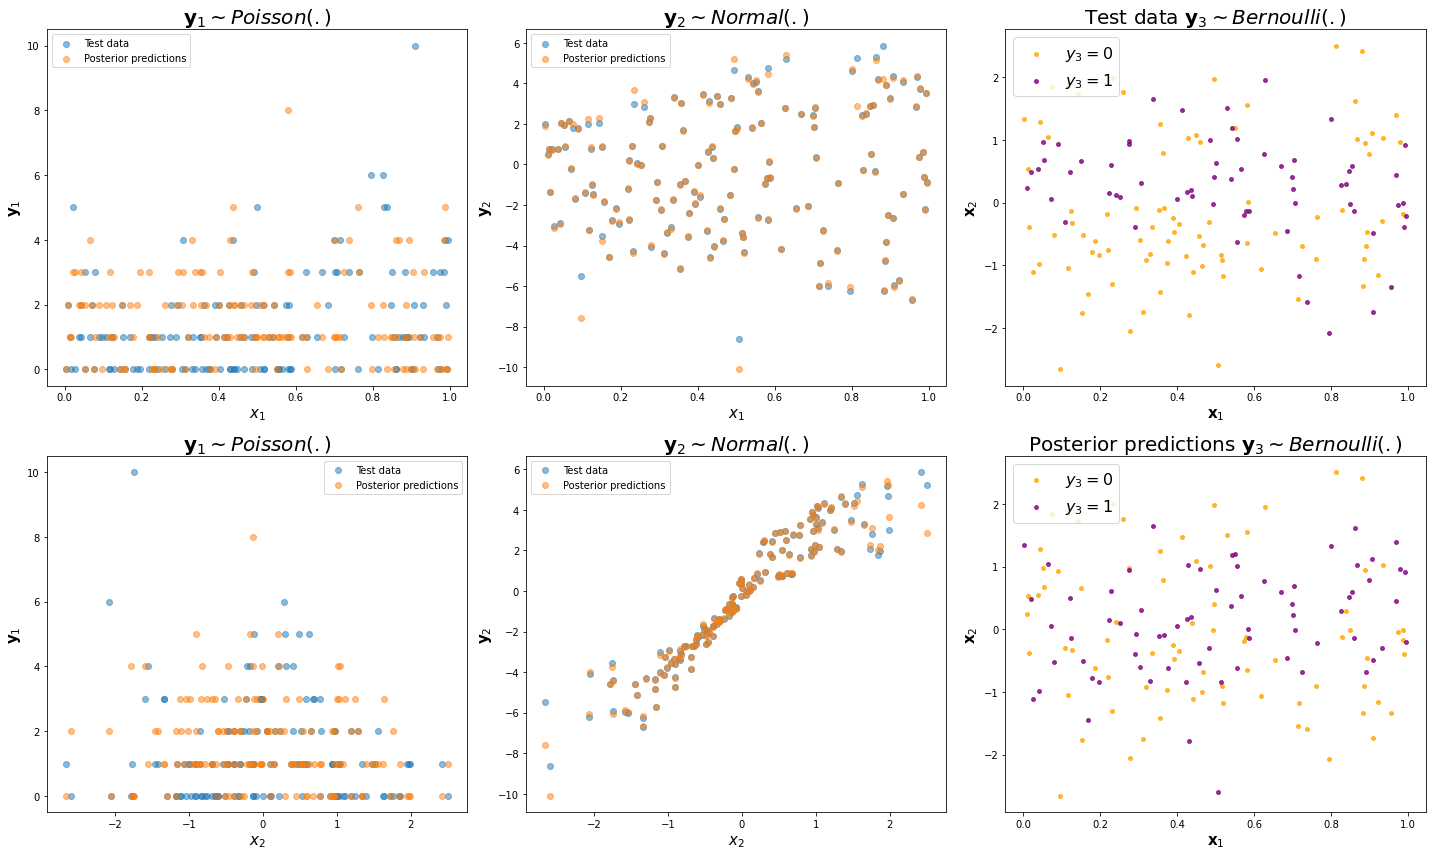

In [141]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,12))

for i in range(2):
    for j in range(2):
        ax[i,j].scatter(test_x[:,i], test_y[:,j], alpha = 0.5, label='Test data')
        ax[i,j].scatter(test_x[:,i], y_sim[:,j].cpu().detach().numpy(), alpha=0.5, label='Posterior predictions')
        ax[i,j].legend()
        
idx_0 = (test_y[:,2]==0).nonzero().flatten()
idx_1 = (test_y[:,2]==1).nonzero().flatten()

ax[0,2].scatter(test_x[idx_0,0], test_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
ax[0,2].scatter(test_x[idx_1,0], test_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
ax[0,2].legend(loc=2, prop={'size': 16})

ax[0,2].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
ax[0,2].set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
ax[0,2].set_title(r"Test data $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

idx_0 = (y_sim[:,2]==0).nonzero().flatten()
idx_1 = (y_sim[:,2]==1).nonzero().flatten()

ax[1,2].scatter(test_x[idx_0,0], test_x[idx_0,1], s=15, alpha=.8, marker='o', c="orange", label=r'$y_3=0$')
ax[1,2].scatter(test_x[idx_1,0], test_x[idx_1,1].cpu().detach().numpy(), s=15, alpha=.8, marker='o', c="purple", label=r'$y_3=1$')
ax[1,2].legend(loc=2, prop={'size': 16})

ax[1,2].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})
ax[1,2].set_ylabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})
ax[1,2].set_title(r"Posterior predictions $\mathbf{y}_3 \sim Bernoulli(.)$", fontsize=20);

ax[0,0].set_ylabel(r"$\mathbf{y}_1$", fontdict={'fontsize':15})
ax[0,0].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1,0].set_ylabel(r"$\mathbf{y}_1$", fontdict={'fontsize':15})
ax[1,0].set_xlabel(r"$x_2$", fontdict={'fontsize':15})
ax[0,0].set_title(r"$\mathbf{y}_1 \sim Poisson(.)$", fontsize=20)
ax[1,0].set_title(r"$\mathbf{y}_1 \sim Poisson(.)$", fontsize=20)

ax[0,1].set_ylabel(r"$\mathbf{y}_2$", fontdict={'fontsize':15})
ax[0,1].set_xlabel(r"$x_1$", fontdict={'fontsize':15})
ax[1,1].set_ylabel(r"$\mathbf{y}_2$", fontdict={'fontsize':15})
ax[1,1].set_xlabel(r"$x_2$", fontdict={'fontsize':15})
ax[0,1].set_title(r"$\mathbf{y}_2 \sim Normal(.)$", fontsize=20)
ax[1,1].set_title(r"$\mathbf{y}_2 \sim Normal(.)$", fontsize=20)
# fig.suptitle(r"Latent function $f_1(\mathbf{x})$", fontsize=20)

fig.tight_layout()

In [122]:
model.eval()

with torch.no_grad():
    latent_dist_draw = model.variational_strategy.latent_dist.sample(torch.Size([1000]))
    latent_dist_draw = latent_dist_draw.cpu()
    
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()
    test = model.variational_strategy.latent_dist

lower_latent, mean_latent, upper_latent = percentiles_from_samples(latent_dist_draw)


In [123]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [124]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

<AxesSubplot:>

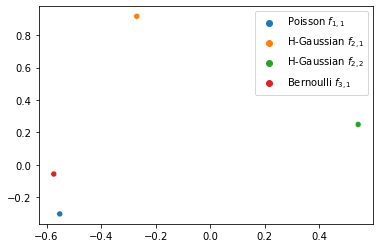

In [125]:
labels = [r"Poisson $f_{1,1}$", r"H-Gaussian $f_{2,1}$", r"H-Gaussian $f_{2,2}$", r"Bernoulli $f_{3,1}$"]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

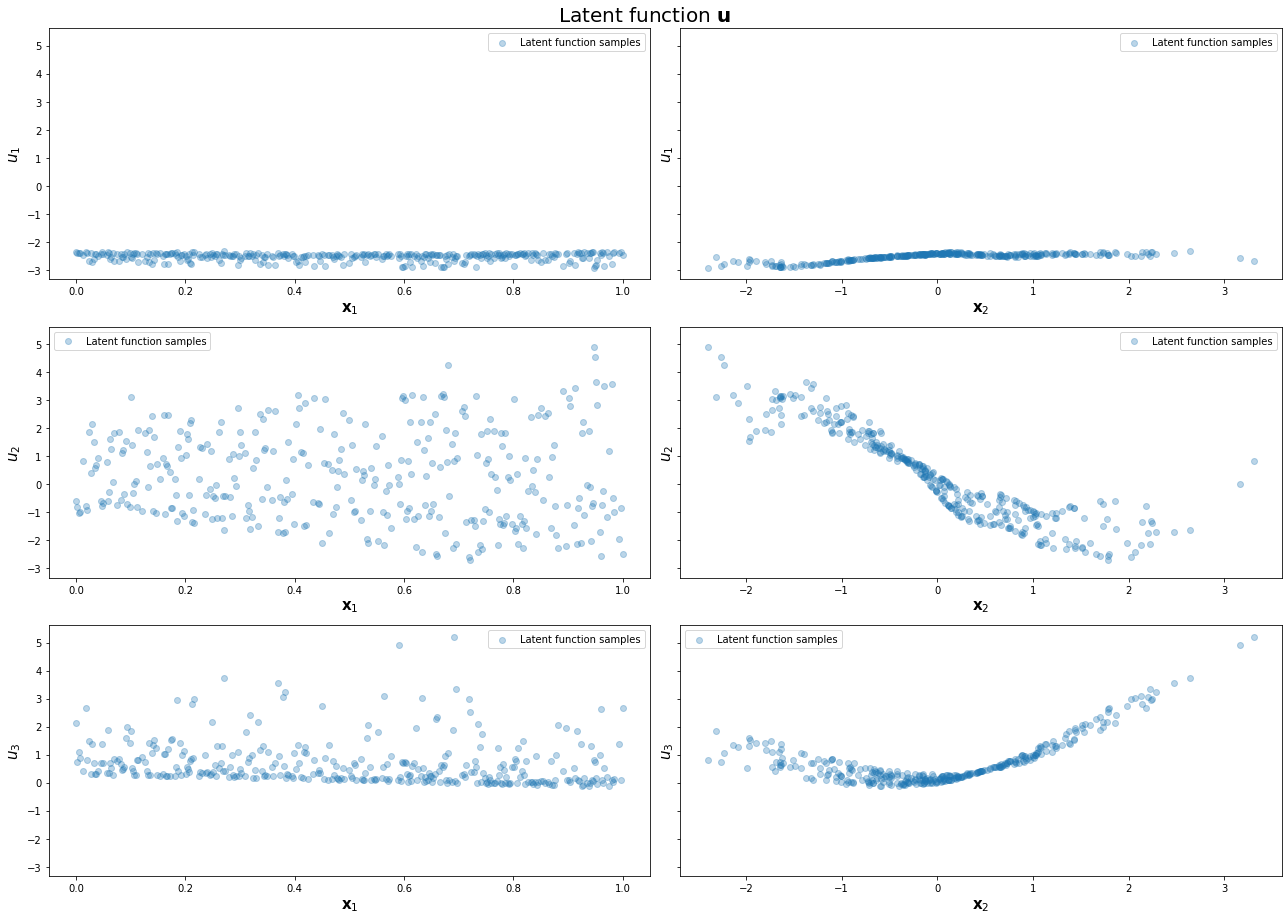

In [140]:
# visualize the result
fig, func = plt.subplots(latent_dist_draw.size(-2), input_dim, figsize=(18, 13), sharey=True)

scale_adj = torch.tensor([-.8, .8]) # scale the true GP
# active_dims_ = [[0], [0], [1], [1], [1]]
for i in range(latent_dist_draw.size(-2)):
    for j in range(input_dim):
        # if active_dims_[i] == [j]:
        indices = np.argsort(train_x[:,j])
        func[i,j].scatter(train_x[indices,j], mean_latent[i,indices], label='Latent function samples', alpha=0.3)
        # func[i,j].fill_between(
        #     train_x[indices,j], lower_latent[i,indices],
        #     upper_latent[i,indices], alpha=0.1, color=line.get_color()
        # )
        func[i,j].legend()
        
func[0,0].set_ylabel(r"$u_1$", fontdict={'fontsize':15})
func[0,0].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})

func[1,0].set_ylabel(r"$u_2$", fontdict={'fontsize':15})
func[1,0].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})

func[2,0].set_ylabel(r"$u_3$", fontdict={'fontsize':15})
func[2,0].set_xlabel(r"$\mathbf{x}_1$", fontdict={'fontsize':15})

func[0,1].set_ylabel(r"$u_1$", fontdict={'fontsize':15})
func[0,1].set_xlabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})

func[1,1].set_ylabel(r"$u_2$", fontdict={'fontsize':15})
func[1,1].set_xlabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})

func[2,1].set_ylabel(r"$u_3$", fontdict={'fontsize':15})
func[2,1].set_xlabel(r"$\mathbf{x}_2$", fontdict={'fontsize':15})

fig.suptitle(r"Latent function $\mathbf{u}$", fontsize=20)

fig.tight_layout()